<h1>Yelp - building star rating classifier</h1>

<p style="font-size:18px;color:blue;">Followring simple excercise demonstrates star rating classifier, particularly Naive Bayes.</p>

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('yelp').getOrCreate()

In [3]:
biz = spark.read.json('d:/O2_CaseStudy/business.json')

In [4]:
review = spark.read.json('d:/O2_CaseStudy/review.json')

<h3>Average star rating less than 3 by cities</h3>

In [41]:
# Sum by Agg
group_data = biz.groupBy("city")
result = group_data.agg({'stars':'avg'})
result = result.orderBy(result['avg(stars)'].desc())
result = result.filter(result['avg(stars)'] < 3.0).toPandas()
result.columns = ['City', 'AvgStars']

In [42]:
result.head(5)

,City,AvgStars
0,Dorval,2.989691
1,Brookpark,2.968750
2,Greenfield Park,2.950000
3,Rexdale,2.900000
4,St-Leonard,2.900000


In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

<h3>Top 20 results of Average star rating less than 3 by cities - graphical interpretation with Seaborn</h3>

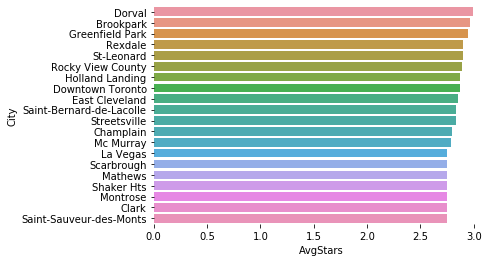

In [43]:
sns.barplot(data=result.head(20), x='AvgStars', y='City')
sns.despine(left = True, bottom = True)
plt.show()

## NLP for Earl of Sandwich - Naive Bayes classification for stars rating

In [59]:
from pyspark.ml.feature import (Tokenizer, StopWordsRemover, CountVectorizer,
                                IDF, StringIndexer)
import numpy as np

In [159]:
eos = np.array(biz.filter(biz['name'] == 'Earl of Sandwich').select('business_id').collect())

In [160]:
eos

array([['DEBqmgxv2yhJ93LqGpKltg'],
       ['fE7x3Ui2mzdwdfJnd7r_1g'],
       ['DkYS3arLOhA8si5uUEmHOw'],
       ['Ffhe2cmRyloz3CCdRGvHtA'],
       ['3fT1kcQ-MVEImGHa3hll5w']], dtype='<U22')

In [165]:
earl_of_sandwich = review.filter("business_id in ('DEBqmgxv2yhJ93LqGpKltg','fE7x3Ui2mzdwdfJnd7r_1g','DkYS3arLOhA8si5uUEmHOw','Ffhe2cmRyloz3CCdRGvHtA','3fT1kcQ-MVEImGHa3hll5w')")

In [166]:
earl_of_sandwich.groupBy('stars').count().show()

+-----+-----+
|stars|count|
+-----+-----+
|  1.0|  141|
|  4.0| 1889|
|  3.0|  704|
|  2.0|  246|
|  5.0| 2875|
+-----+-----+



In [60]:
earl_of_sandwich.columns

['business_id',
 'cool',
 'date',
 'funny',
 'review_id',
 'stars',
 'text',
 'useful',
 'user_id']

In [167]:
from pyspark.sql.functions import length

In [168]:
earl_of_sandwich = earl_of_sandwich.withColumn('length', length(earl_of_sandwich['text']))

In [169]:
from pyspark.sql.functions import format_number

In [170]:
earl_of_sandwich.columns

['business_id',
 'cool',
 'date',
 'funny',
 'review_id',
 'stars',
 'text',
 'useful',
 'user_id',
 'length']

In [171]:
earl_of_sandwich.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- length: integer (nullable = true)



In [172]:
tokenizer = Tokenizer(inputCol='text', outputCol='token_text')
stop_words_remove = StopWordsRemover(inputCol='token_text', outputCol='stop_token')
count_vec = CountVectorizer(inputCol='stop_token', outputCol='c_vec')
idf = IDF(inputCol='c_vec', outputCol='tf_idf')
stars_class = StringIndexer(inputCol='stars', outputCol='label')

In [173]:
from pyspark.ml.feature import VectorAssembler

In [174]:
clean_up = VectorAssembler(inputCols=['tf_idf', 'length'], outputCol='features')

In [175]:
from pyspark.ml.classification import NaiveBayes

In [176]:
nb = NaiveBayes()

In [177]:
from pyspark.ml import Pipeline

In [178]:
data_prep_pipe = Pipeline(stages=[stars_class, tokenizer,
                                 stop_words_remove, count_vec, idf,
                                 clean_up])

In [179]:
cleaner = data_prep_pipe.fit(earl_of_sandwich)

In [180]:
clean_data = cleaner.transform(earl_of_sandwich)

In [181]:
clean_data = clean_data.select('label', 'features')

In [182]:
clean_data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(26923,[4,9,12,10...|
|  4.0|(26923,[0,2,17,54...|
|  4.0|(26923,[0,1,3,18,...|
|  2.0|(26923,[11,34,42,...|
|  0.0|(26923,[1,2,11,15...|
|  3.0|(26923,[10,16,79,...|
|  0.0|(26923,[0,4,8,12,...|
|  4.0|(26923,[0,4,12,16...|
|  1.0|(26923,[0,1,5,7,8...|
|  2.0|(26923,[1,15,16,3...|
|  0.0|(26923,[1,2,13,14...|
|  1.0|(26923,[0,1,5,13,...|
|  1.0|(26923,[1,2,4,5,7...|
|  1.0|(26923,[2,5,15,32...|
|  1.0|(26923,[0,1,13,16...|
|  2.0|(26923,[1,2,8,15,...|
|  3.0|(26923,[1,3,6,7,8...|
|  4.0|(26923,[8,76,192,...|
|  0.0|(26923,[0,1,14,32...|
|  2.0|(26923,[1,19,46,7...|
+-----+--------------------+
only showing top 20 rows



In [183]:
training, test = clean_data.randomSplit([0.7, 0.3])

In [184]:
star_detector = nb.fit(training)

In [185]:
earl_of_sandwich.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- length: integer (nullable = true)



In [186]:
test_results = star_detector.transform(test)

In [187]:
test_results.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(26923,[0,3,6,12,...|[-2257.7283223200...|[0.99994534358914...|       0.0|
|  0.0|(26923,[0,4,8,12,...|[-3737.3251404332...|[1.0,7.1426571945...|       0.0|
|  0.0|(26923,[2,3,12,18...|[-1901.3512612624...|[0.99999993472454...|       0.0|
|  1.0|(26923,[0,1,3,19,...|[-838.12138669477...|[1.51381796237448...|       1.0|
|  1.0|(26923,[0,1,5,7,8...|[-5549.0814089650...|[1.87614452513813...|       2.0|
|  1.0|(26923,[0,1,13,16...|[-2203.5453882083...|[0.99868472518438...|       0.0|
|  1.0|(26923,[1,2,4,5,7...|[-1539.4068126819...|[3.25173402052072...|       1.0|
|  1.0|(26923,[1,2,5,7,8...|[-738.54945014640...|[0.99884944171548...|       0.0|
|  1.0|(26923,[1,5,13,14...|[-1651.7869631722...|[0.99999401430747...|       0.0|
|  1.0|(26923,[2

In [188]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [189]:
acc_eval = MulticlassClassificationEvaluator()

In [190]:
acc = acc_eval.evaluate(test_results)

In [191]:
print('ACC of NB Model')
print(acc)

ACC of NB Model
0.501903565387439


<p style="font-size:16px;color:blue;">Accuracy is the same like if we simulate swapping the coin. It is due to small data set or text reviews provided by <b><i>Earl of Sandwich</i></b>. This can be improved by another ML model such as Random Forest, SVM or neural network.</p>